In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV,LassoCV
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Pandas version \t', pd.__version__)
print('Numpy version \t', np.__version__)
print('Matplotlib version \t', matplotlib.__version__)
print('Seaborn version \t', sns.__version__)
print('Sklearn version \t', sklearn.__version__)  



Pandas version 	 1.0.5
Numpy version 	 1.18.5
Matplotlib version 	 3.2.2
Seaborn version 	 0.10.1
Sklearn version 	 0.23.1


##### General Approach

Step 1 : EDA
1. Load the data
2. Inspect the data / High level overview
3. Check if any data is blank and perform data quality checks as below
4. drop column which has ids, nan more than 10 % etc
5. Imput the data based on data description
6. transform as per meta data all columns [categorical]
7. Handle outliers 
8. Handle Ordernal in columns
9. Valirous plots to understand the data 

Step 2 : Preparing data for regression
10. Create Dummy variables
11. Original columns are dropped
Step 3: Train / Test Data Split / Scalling the training numeric vars
12. Train & Test split 70 / 30
13. Scale the train data only the numeric columns
Step 4: Building Model / Choose optimal number of var count for RFE
13. Perform Linear Regression using RFE
14. Choose top 70 variables
Step 5: Ridge Implementation
15. Using alpha=0.001 
16. Find optimal alpha
Step 6: Lasso Implementation
17. Using alpha=0.001 
18. Find optimal alpha

In [3]:
# read the data
data = pd.read_csv('train.csv')
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check shape
data.shape

(1460, 81)

In [5]:
# Check basic info of data
data.describe([0.25,0.5,0.75,0.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
99%,1445.410000,190.000000,141.000000,37567.640000,10.000000,9.000000,2009.000000,2009.000000,791.920000,1572.410000,...,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,2010.000000,442567.010000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# Data quality
# Columns data type
# Null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Considering 10% as threshold and dropping the column having more then the threshold 
## Before dropping validate data description

In [7]:
round(data.isnull().sum()/len(data.index),2)[round(data.isnull().sum()/
                                                                 len(data.index),2).values>0.1]

LotFrontage    0.18
Alley          0.94
FireplaceQu    0.47
PoolQC         1.00
Fence          0.81
MiscFeature    0.96
dtype: float64

### Validate all top null values using data description
1. LotFrontage Numeric column with NA can be dropped
2. Rest cann;t drop as they are categorical values and it has some meaning
3. MoSold can be dropped.

In [8]:
data.drop(columns=['Id','LotFrontage','MoSold'], axis=1, inplace=True)

In [9]:
data.shape

(1460, 78)

## Check NaN values before imputing them

In [10]:
data[data.isna().any(axis=1)]

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2008,WD,Normal,208500
1,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,2007,WD,Normal,181500
2,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2008,WD,Normal,223500
3,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NaN,NaN,NaN,0,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,NaN,0,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2007,WD,Normal,175000
1456,20,RL,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,MnPrv,NaN,0,2010,WD,Normal,210000
1457,70,RL,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,GdPrv,Shed,2500,2010,WD,Normal,266500
1458,20,RL,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,NaN,0,2010,WD,Normal,142125


## Imputing Strategy
1. Fill  numeric columns with median value or with -1 depdending on data description [-1 for GarageYrBlt, median for MasVnrArea]
2. Fill columns with either None or NA string depdending on data description
3. most frequest for Electrical  columns

In [11]:
s_imputer_1 = SimpleImputer(strategy='constant', fill_value=data.MasVnrArea.median())
s_imputer_2 = SimpleImputer(strategy='constant', fill_value="None")
s_imputer_3 = SimpleImputer(strategy='most_frequent')
s_imputer_4 = SimpleImputer(strategy='constant', fill_value="NA")
s_imputer_5 = SimpleImputer(strategy='constant', fill_value=-1)

## Define Imputing columns based on Imputing strategy

In [12]:
# filling missing value with iterative imputer
feat_1 = [ 'MasVnrArea']
feat_2 = ['MasVnrType']
feat_3 = ['Electrical']
feat_4 = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
          'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
          'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'PoolQC']
feat_5 = [ 'GarageYrBlt']

In [13]:
## Perform Imputing

In [14]:
data[feat_1] = s_imputer_1.fit_transform(data[feat_1])
data[feat_2] = s_imputer_2.fit_transform(data[feat_2])
data[feat_3] = s_imputer_3.fit_transform(data[feat_3])
data[feat_4] = s_imputer_4.fit_transform(data[feat_4])
data[feat_5] = s_imputer_5.fit_transform(data[feat_5])

## Validate missing values to double check if all are replaced based on Imputing strategy

In [15]:
data[data.isna().any(axis=1)]

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice


## Based on column where years are present lets creata new column to this will have value as max - current value

In [16]:
data['YearBuilt_Old'] = data.YearBuilt.max()-data.YearBuilt
data['YearRemodAdd_Old'] = data.YearRemodAdd.max()-data.YearRemodAdd
data['GarageYrBlt_Old'] = data.GarageYrBlt.max()-data.GarageYrBlt
data['YrSold_Old'] = data.YrSold.max()-data.YrSold
data[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].sample(10)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
19,1958,1965,1958.0,2009,52,45,52.0,1
692,1989,1990,1989.0,2006,21,20,21.0,4
1033,2002,2002,2002.0,2006,8,8,8.0,4
598,1977,1977,1977.0,2006,33,33,33.0,4
358,1958,1958,1958.0,2006,52,52,52.0,4
1301,1942,1950,1942.0,2009,68,60,68.0,1
96,1999,1999,1999.0,2006,11,11,11.0,4
399,2006,2007,2007.0,2009,4,3,3.0,1
1446,1962,1962,1962.0,2010,48,48,48.0,0
530,1988,1989,1988.0,2008,22,21,22.0,2


## Remove Original columns --> all Yrs columns

In [17]:
data.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'], axis=1, inplace=True)

## Handling outliers

In [18]:
numeric_vars = ['MSSubClass','PoolArea','MasVnrArea','TotRmsAbvGrd','Fireplaces','BedroomAbvGr','KitchenAbvGr','FullBath','HalfBath','BsmtHalfBath','BsmtFullBath','GrLivArea','LowQualFinSF','2ndFlrSF','1stFlrSF','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1','OverallCond','OverallQual','LotArea','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','YearBuilt_Old','YearRemodAdd_Old','GarageYrBlt_Old','YrSold_Old',
           'SalePrice']
def drop_outliers(x):
    list = []
    for col in numeric_vars:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

data = drop_outliers(data)

In [19]:
data.shape

(1441, 78)

### Handle orders in columns, first check using data descrption then map it accodingly.

In [20]:
data[['LotShape','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','Fence','PoolQC'
             ]].head()

,LotShape,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,Fence,PoolQC
0,Reg,Gtl,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,NA,RFn,TA,TA,NA,NA
1,Reg,Gtl,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,TA,RFn,TA,TA,NA,NA
2,IR1,Gtl,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,TA,RFn,TA,TA,NA,NA
3,IR1,Gtl,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Gd,Unf,TA,TA,NA,NA
4,IR1,Gtl,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,TA,RFn,TA,TA,NA,NA


## Mapping based on data description

In [21]:
data['LotShape'] = data.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

data['LandSlope'] = data.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})

data['ExterQual'] = data.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

data['ExterCond'] = data.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

data['BsmtQual'] = data.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

data['BsmtCond'] = data.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

data['BsmtExposure'] = data.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})

data['BsmtFinType1'] = data.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})

data['BsmtFinType2'] = data.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})

data['HeatingQC'] = data.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

data['CentralAir'] = data.CentralAir.map({'N':0,'Y':1})

data['KitchenQual'] = data.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

data['FireplaceQu'] = data.FireplaceQu.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

data['GarageFinish'] = data.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})

data['GarageQual'] = data.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

data['GarageCond'] = data.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

data['Fence'] = data.Fence.map({'NA':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4})

##
data['PoolQC'] = data.PoolQC.map({'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})



## Validation if orders are handeled correctly

In [22]:
data[['LotShape','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','Fence','PoolQC'
             ]].head()

,LotShape,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,Fence,PoolQC
0,3,0,3,2,4,3,1,6,1,4,1,3,0,2,3,3,0,0
1,3,0,2,2,4,3,4,5,1,4,1,2,3,2,3,3,0,0
2,0,0,3,2,4,3,2,6,1,4,1,3,3,2,3,3,0,0
3,0,0,2,2,3,4,1,5,1,3,1,3,4,1,3,3,0,0
4,0,0,3,2,4,3,3,6,1,4,1,3,3,2,3,3,0,0


In [23]:
## Plot Heatmap of all numerical column to see correlation between with sale price

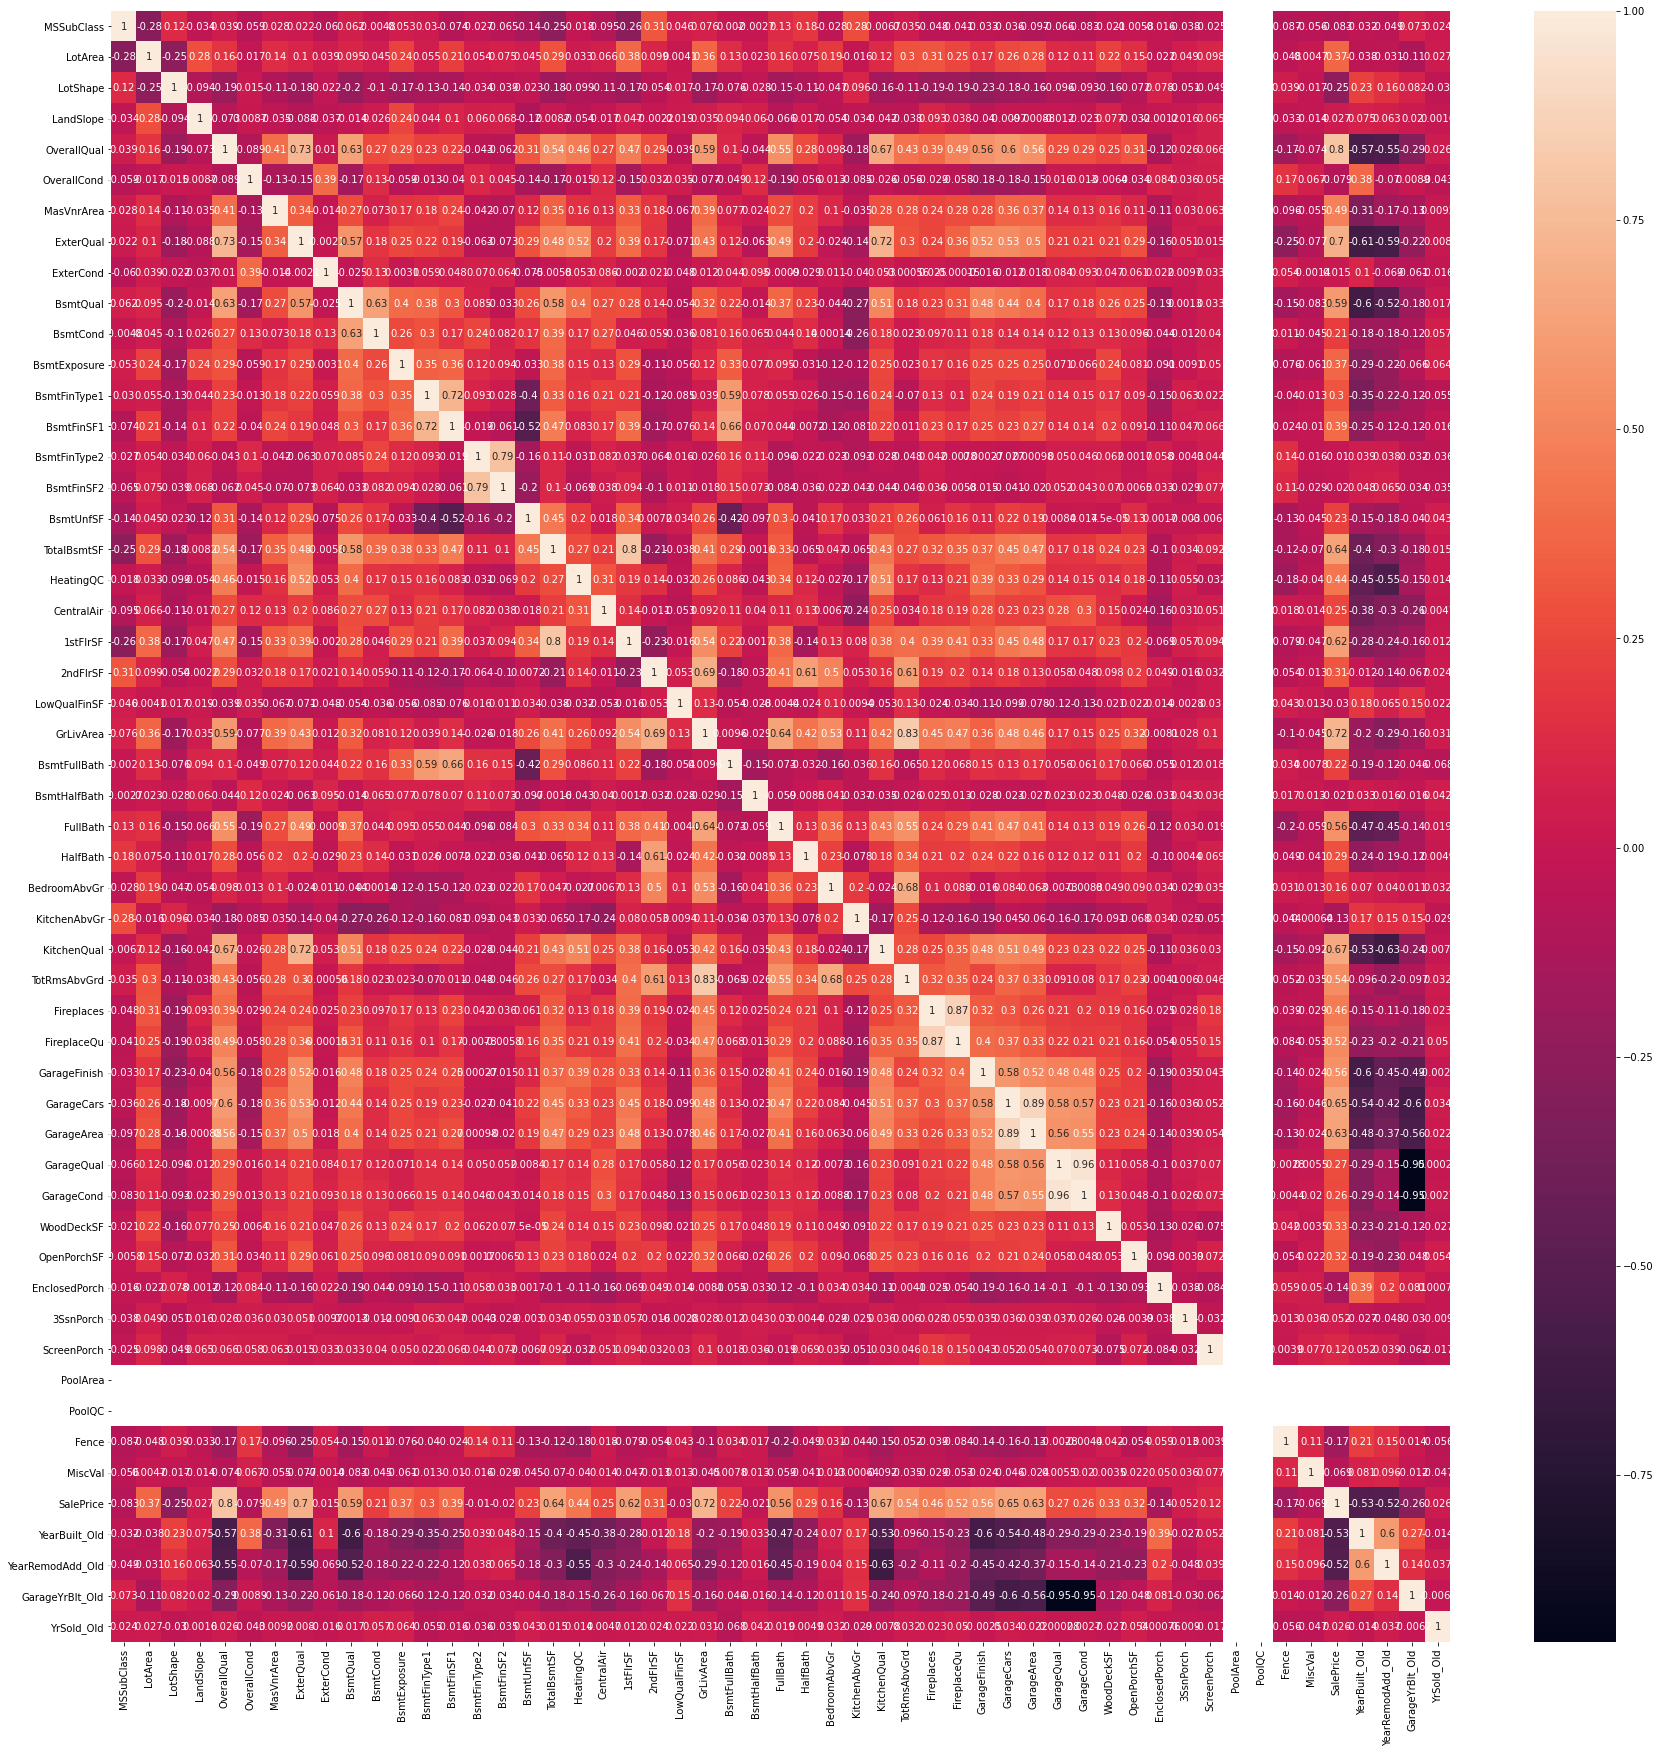

In [24]:
plt.figure(figsize=(30,30))
sns.heatmap(data[list(data.dtypes[data.dtypes!='object'].index)].corr(),annot=True)
plt.show()

In [25]:
## Plot various variable relation with sale price


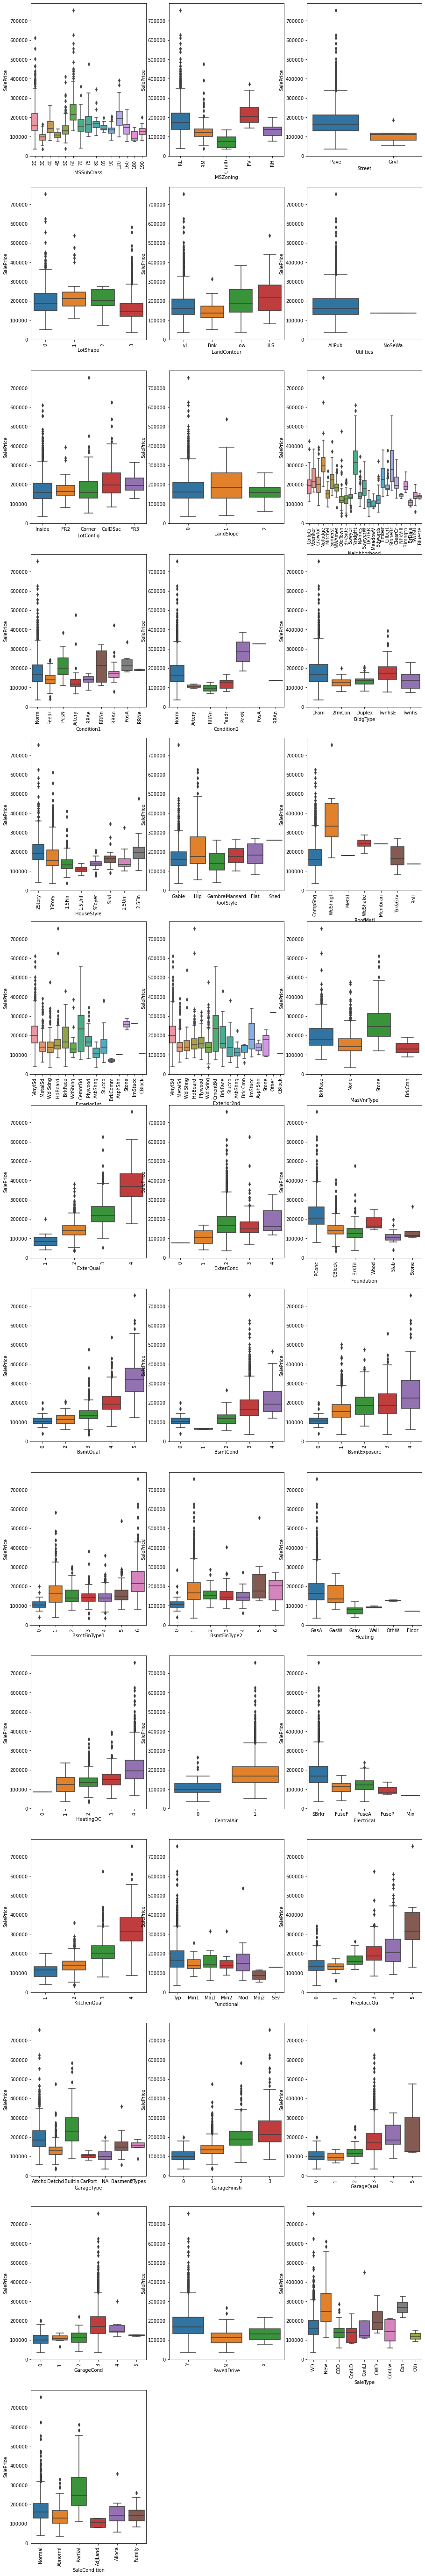

In [26]:
plt.figure(figsize=(15,100))

plt.subplot(14,3,1)
ax1 = sns.boxplot(x='MSSubClass',y='SalePrice',data=data)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

plt.subplot(14,3,2)
ax2 = sns.boxplot(x='MSZoning',y='SalePrice',data=data)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

plt.subplot(14,3,3)
sns.boxplot(x='Street',y='SalePrice',data=data)

plt.subplot(14,3,4)
ax4 = sns.boxplot(x='LotShape',y='SalePrice',data=data)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

plt.subplot(14,3,5)
sns.boxplot(x='LandContour',y='SalePrice',data=data)


plt.subplot(14,3,6)
sns.boxplot(x='Utilities',y='SalePrice',data=data)

plt.subplot(14,3,7)
sns.boxplot(x='LotConfig',y='SalePrice',data=data)

plt.subplot(14,3,8)
ax8 = sns.boxplot(x='LandSlope',y='SalePrice',data=data)
ax8.set_xticklabels(ax8.get_xticklabels(),rotation=90)

plt.subplot(14,3,9)
ax9 = sns.boxplot(x='Neighborhood',y='SalePrice',data=data)
ax9.set_xticklabels(ax9.get_xticklabels(),rotation=90)

plt.subplot(14,3,10)
ax10 = sns.boxplot(x='Condition1',y='SalePrice',data=data)
ax10.set_xticklabels(ax10.get_xticklabels(),rotation=90)

plt.subplot(14,3,11)
ax11 = sns.boxplot(x='Condition2',y='SalePrice',data=data)
ax11.set_xticklabels(ax11.get_xticklabels(),rotation=90)

plt.subplot(14,3,12)
sns.boxplot(x='BldgType',y='SalePrice',data=data)

plt.subplot(14,3,13)
ax13 = sns.boxplot(x='HouseStyle',y='SalePrice',data=data)
ax13.set_xticklabels(ax13.get_xticklabels(),rotation=90)

plt.subplot(14,3,14)
sns.boxplot(x='RoofStyle',y='SalePrice',data=data)

plt.subplot(14,3,15)
ax15 = sns.boxplot(x='RoofMatl',y='SalePrice',data=data)
ax15.set_xticklabels(ax15.get_xticklabels(),rotation=90)

plt.subplot(14,3,16)
ax16 = sns.boxplot(x='Exterior1st',y='SalePrice',data=data)
ax16.set_xticklabels(ax16.get_xticklabels(),rotation=90)

plt.subplot(14,3,17)
ax17 = sns.boxplot(x='Exterior2nd',y='SalePrice',data=data)
ax17.set_xticklabels(ax17.get_xticklabels(),rotation=90)

plt.subplot(14,3,18)
ax18 = sns.boxplot(x='MasVnrType',y='SalePrice',data=data)
ax18.set_xticklabels(ax18.get_xticklabels(),rotation=90)


plt.subplot(14,3,19)
ax19 = sns.boxplot(x='ExterQual',y='SalePrice',data=data)
ax19.set_xticklabels(ax19.get_xticklabels(),rotation=90)

plt.subplot(14,3,20)
ax20 = sns.boxplot(x='ExterCond',y='SalePrice',data=data)
ax20.set_xticklabels(ax20.get_xticklabels(),rotation=90)

plt.subplot(14,3,21)
ax21 = sns.boxplot(x='Foundation',y='SalePrice',data=data)
ax21.set_xticklabels(ax21.get_xticklabels(),rotation=90)

plt.subplot(14,3,22)
ax22 = sns.boxplot(x='BsmtQual',y='SalePrice',data=data)
ax22.set_xticklabels(ax22.get_xticklabels(),rotation=90)


plt.subplot(14,3,23)
ax23 = sns.boxplot(x='BsmtCond',y='SalePrice',data=data)
ax23.set_xticklabels(ax23.get_xticklabels(),rotation=90)


plt.subplot(14,3,24)
ax24 = sns.boxplot(x='BsmtExposure',y='SalePrice',data=data)
ax24.set_xticklabels(ax24.get_xticklabels(),rotation=90)


plt.subplot(14,3,25)
ax25 = sns.boxplot(x='BsmtFinType1',y='SalePrice',data=data)
ax25.set_xticklabels(ax25.get_xticklabels(),rotation=90)

plt.subplot(14,3,26)
ax26 = sns.boxplot(x='BsmtFinType2',y='SalePrice',data=data)
ax26.set_xticklabels(ax26.get_xticklabels(),rotation=90)

plt.subplot(14,3,27)
sns.boxplot(x='Heating',y='SalePrice',data=data)

plt.subplot(14,3,28)
ax28 = sns.boxplot(x='HeatingQC',y='SalePrice',data=data)
ax28.set_xticklabels(ax28.get_xticklabels(),rotation=90)

plt.subplot(14,3,29)
sns.boxplot(x='CentralAir',y='SalePrice',data=data)

plt.subplot(14,3,30)
sns.boxplot(x='Electrical',y='SalePrice',data=data)


plt.subplot(14,3,31)
ax31 = sns.boxplot(x='KitchenQual',y='SalePrice',data=data)
ax31.set_xticklabels(ax31.get_xticklabels(),rotation=90)

plt.subplot(14,3,32)
sns.boxplot(x='Functional',y='SalePrice',data=data)

plt.subplot(14,3,33)
ax33 = sns.boxplot(x='FireplaceQu',y='SalePrice',data=data)
ax33.set_xticklabels(ax33.get_xticklabels(),rotation=90)

plt.subplot(14,3,34)
sns.boxplot(x='GarageType',y='SalePrice',data=data)

plt.subplot(14,3,35)
sns.boxplot(x='GarageFinish',y='SalePrice',data=data)


plt.subplot(14,3,36)
ax36 = sns.boxplot(x='GarageQual',y='SalePrice',data=data)
ax36.set_xticklabels(ax36.get_xticklabels(),rotation=90)

plt.subplot(14,3,37)
ax37 = sns.boxplot(x='GarageCond',y='SalePrice',data=data)
ax37.set_xticklabels(ax37.get_xticklabels(),rotation=90)

plt.subplot(14,3,38)
ax38 = sns.boxplot(x='PavedDrive',y='SalePrice',data=data)
ax38.set_xticklabels(ax38.get_xticklabels(),rotation=90)

plt.subplot(14,3,39)
ax39 = sns.boxplot(x='SaleType',y='SalePrice',data=data)
ax39.set_xticklabels(ax39.get_xticklabels(),rotation=90)

plt.subplot(14,3,40)
ax40 = sns.boxplot(x='SaleCondition',y='SalePrice',data=data)
ax40.set_xticklabels(ax40.get_xticklabels(),rotation=90)


plt.show()

### Creating Dummies for all categorical variables 

In [27]:
# creating dummies for categorical variable : MSZoning
MSZoning = pd.get_dummies(data['MSZoning'], drop_first = True)
data =  pd.concat([data,MSZoning],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old,FV,RH,RL,RM
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,Normal,208500,7,7,7.0,2,0,0,1,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,Normal,181500,34,34,34.0,3,0,0,1,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,Normal,223500,9,8,9.0,2,0,0,1,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,Abnorml,140000,95,40,12.0,4,0,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,Normal,250000,10,10,10.0,2,0,0,1,0


In [28]:
# creating dummies for categorical variable : Street
Street = pd.get_dummies(data['Street'], drop_first = True)
data =  pd.concat([data,Street],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old,FV,RH,RL,RM,Pave
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,208500,7,7,7.0,2,0,0,1,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,181500,34,34,34.0,3,0,0,1,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,223500,9,8,9.0,2,0,0,1,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,140000,95,40,12.0,4,0,0,1,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,250000,10,10,10.0,2,0,0,1,0,1


In [29]:
# creating dummies for categorical variable : LandContour
LandContour = pd.get_dummies(data['LandContour'], drop_first = True)
data =  pd.concat([data,LandContour],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageYrBlt_Old,YrSold_Old,FV,RH,RL,RM,Pave,HLS,Low,Lvl
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,7.0,2,0,0,1,0,1,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,34.0,3,0,0,1,0,1,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,9.0,2,0,0,1,0,1,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,12.0,4,0,0,1,0,1,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,10.0,2,0,0,1,0,1,0,0,1


In [30]:
# creating dummies for categorical variable : Utilities
Utilities = pd.get_dummies(data['Utilities'], drop_first = True)
data =  pd.concat([data,Utilities],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,YrSold_Old,FV,RH,RL,RM,Pave,HLS,Low,Lvl,NoSeWa
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,2,0,0,1,0,1,0,0,1,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,3,0,0,1,0,1,0,0,1,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,2,0,0,1,0,1,0,0,1,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,4,0,0,1,0,1,0,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,2,0,0,1,0,1,0,0,1,0


In [31]:
# creating dummies for categorical variable : LotConfig
LotConfig = pd.get_dummies(data['LotConfig'], drop_first = True)
data =  pd.concat([data,LotConfig],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,RM,Pave,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,0,0,1,0,0,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,0,0,1,0,0,1,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,0,0,1,0,0,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,0,1,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,0,0,1,0,0,1,0,0


In [32]:
# creating dummies for categorical variable : Neighborhood
Neighborhood = pd.get_dummies(data['Neighborhood'], drop_first = True)
data =  pd.concat([data,Neighborhood],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
# creating dummies for categorical variable : Condition1
Condition1 = pd.get_dummies(data['Condition1'], drop_first = True)
data =  pd.concat([data,Condition1],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,1,0,0,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,1,0,0,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,1,0,0,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,1,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,1,0,0,0,0,0,0


In [34]:
# creating dummies for categorical variable : Condition2
Condition2 = pd.get_dummies(data['Condition2'], drop_first = True)
data =  pd.concat([data,Condition2],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,RRAe,RRAn,RRNe,RRNn,Feedr,Norm,PosA,PosN,RRAn,RRNn
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,1,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,0,1,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,1,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,1,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,0,1,0,0,0,0


In [35]:
# creating dummies for categorical variable : BldgType
BldgType = pd.get_dummies(data['BldgType'], drop_first = True)
data =  pd.concat([data,BldgType],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Feedr,Norm,PosA,PosN,RRAn,RRNn,2fmCon,Duplex,Twnhs,TwnhsE
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,0,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,0


In [36]:
# creating dummies for categorical variable : HouseStyle
HouseStyle = pd.get_dummies(data['HouseStyle'], drop_first = True)
data =  pd.concat([data,HouseStyle],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,1,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,0,1,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
# creating dummies for categorical variable : RoofStyle
RoofStyle = pd.get_dummies(data['RoofStyle'], drop_first = True)
data =  pd.concat([data,RoofStyle],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,1,0,0,1,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,0,1,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,1,0,0,1,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,1,0,0,1,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,1,0,0,1,0,0,0,0


In [38]:
# creating dummies for categorical variable : RoofMatl
RoofMatl = pd.get_dummies(data['RoofMatl'], drop_first = True)
data =  pd.concat([data,RoofMatl],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Gambrel,Hip,Mansard,Shed,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# creating dummies for categorical variable : Exterior1st
Exterior1st = pd.get_dummies(data['Exterior1st'], drop_first = True)
data =  pd.concat([data,Exterior1st],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,1,0,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,0,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
# creating dummies for categorical variable : Exterior2nd
Exterior2nd = pd.get_dummies(data['Exterior2nd'], drop_first = True)
data =  pd.concat([data,Exterior2nd],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,1,0,0,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,0,1,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,0,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
# creating dummies for categorical variable : MasVnrType
MasVnrType = pd.get_dummies(data['MasVnrType'], drop_first = True)
data =  pd.concat([data,MasVnrType],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,BrkFace,None,Stone
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,1,0,0,1,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,0,0,0,0,1,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,1,0,0,1,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,0,1,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,1,0,0,1,0,0


In [42]:
# creating dummies for categorical variable : Foundation
Foundation = pd.get_dummies(data['Foundation'], drop_first = True)
data =  pd.concat([data,Foundation],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Wd Sdng,Wd Shng,BrkFace,None,Stone,CBlock,PConc,Slab,Stone,Wood
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,1,0,0,0,1,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,1,0,1,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,1,0,0,0,1,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,1,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,1,0,0,0,1,0,0,0


In [43]:
# creating dummies for categorical variable : Heating
Heating = pd.get_dummies(data['Heating'], drop_first = True)
data =  pd.concat([data,Heating],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,CBlock,PConc,Slab,Stone,Wood,GasA,GasW,Grav,OthW,Wall
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,0,0,0,1,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,1,0,0,0,0,1,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,0,0,0,1,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,0,1,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,0,0,0,1,0,0,0,0


In [44]:
# creating dummies for categorical variable : Electrical
Electrical = pd.get_dummies(data['Electrical'], drop_first = True)
data =  pd.concat([data,Electrical],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Wood,GasA,GasW,Grav,OthW,Wall,FuseF,FuseP,Mix,SBrkr
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,0,0,0,0,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,1


In [45]:
# creating dummies for categorical variable : Functional
Functional = pd.get_dummies(data['Functional'], drop_first = True)
data =  pd.concat([data,Functional],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Mod,Sev,Typ
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,1,0,0,0,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,1,0,0,0,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,1,0,0,0,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,1,0,0,0,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,1,0,0,0,0,0,1


In [46]:
# creating dummies for categorical variable : GarageType
GarageType = pd.get_dummies(data['GarageType'], drop_first = True)
data =  pd.concat([data,GarageType],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Min2,Mod,Sev,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,NA
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,1,1,0,0,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,1,1,0,0,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,1,1,0,0,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,1,0,0,0,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,1,1,0,0,0,0,0


In [47]:
# creating dummies for categorical variable : PavedDrive
PavedDrive = pd.get_dummies(data['PavedDrive'], drop_first = True)
data =  pd.concat([data,PavedDrive],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Sev,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,NA,P,Y
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,1,0,0,0,0,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,1,0,0,0,0,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,1,0,0,0,0,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,0,0,0,1,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,1,0,0,0,0,0,0,1


In [48]:
# creating dummies for categorical variable : SaleType
SaleType = pd.get_dummies(data['SaleType'], drop_first = True)
data =  pd.concat([data,SaleType],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,P,Y,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,1
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,1
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,1,0,0,0,0,0,0,0,1
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,1,0,0,0,0,0,0,0,1
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,1,0,0,0,0,0,0,0,1


In [49]:
# creating dummies for categorical variable : SaleCondition
SaleCondition = pd.get_dummies(data['SaleCondition'], drop_first = True)
data =  pd.concat([data,SaleCondition],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,0,0,1,0,0,0,1,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,0,0,1,0,0,0,1,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,0,0,1,0,0,0,1,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,0,0,1,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,0,0,1,0,0,0,1,0


In [50]:
# creating dummies for categorical variable : MiscFeature
MiscFeature = pd.get_dummies(data['MiscFeature'], drop_first = True)
data =  pd.concat([data,MiscFeature],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial,Othr,Shed
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,0,0,1,0,0,0,1,0,0,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,0,0,1,0,0,0,1,0,0,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,0,0,1,0,0,0,1,0,0,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,0,0,1,0,0,0,0,0,0,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,0,0,1,0,0,0,1,0,0,0


In [51]:
# creating dummies for categorical variable : Alley
Alley = pd.get_dummies(data['Alley'], drop_first = True)
data =  pd.concat([data,Alley],axis = 1)
data.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WD,AdjLand,Alloca,Family,Normal,Partial,Othr,Shed,NA,Pave
0,60,RL,8450,Pave,NA,3,Lvl,AllPub,Inside,0,...,1,0,0,0,1,0,0,0,1,0
1,20,RL,9600,Pave,NA,3,Lvl,AllPub,FR2,0,...,1,0,0,0,1,0,0,0,1,0
2,60,RL,11250,Pave,NA,0,Lvl,AllPub,Inside,0,...,1,0,0,0,1,0,0,0,1,0
3,70,RL,9550,Pave,NA,0,Lvl,AllPub,Corner,0,...,1,0,0,0,0,0,0,0,1,0
4,60,RL,14260,Pave,NA,0,Lvl,AllPub,FR2,0,...,1,0,0,0,1,0,0,0,1,0


# Drop original columns which are already conbverted as dummies

In [52]:

data = data.drop(['MSZoning','Street','LandContour','Utilities','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition','MiscFeature','Alley'],axis = 1)
data.head()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,WD,AdjLand,Alloca,Family,Normal,Partial,Othr,Shed,NA,Pave
0,60,8450,3,0,7,5,196.0,3,2,4,...,1,0,0,0,1,0,0,0,1,0
1,20,9600,3,0,6,8,0.0,2,2,4,...,1,0,0,0,1,0,0,0,1,0
2,60,11250,0,0,7,5,162.0,3,2,4,...,1,0,0,0,1,0,0,0,1,0
3,70,9550,0,0,7,5,0.0,2,2,3,...,1,0,0,0,0,0,0,0,1,0
4,60,14260,0,0,8,5,350.0,3,2,4,...,1,0,0,0,1,0,0,0,1,0


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 1459
Columns: 203 entries, MSSubClass to Pave
dtypes: float64(2), int64(51), uint8(150)
memory usage: 859.0 KB


### see Sale Price plot before scalling 

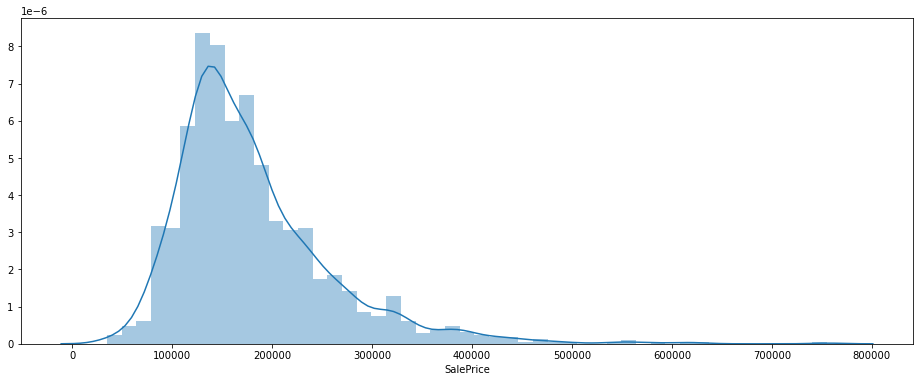

In [54]:
plt.figure(figsize=(16,6))
sns.distplot(data.SalePrice)
plt.show()

## Split Train, Test data sets 70 /  30 ratio

In [55]:
data_train, data_test = train_test_split(data,train_size=0.7, random_state=100)

# Perform scaling on training data using StandardScaler of numeric vars


In [56]:
# Instatiate asn object
scaler = StandardScaler()

# Scale only numeric variable
# Fit_transform on data

data_train[numeric_vars] = scaler.fit_transform(data_train[numeric_vars])
data_test[numeric_vars] = scaler.transform(data_test[numeric_vars])

# Data after Scaling

In [57]:
data_train.describe([0.25,0.5,0.75,0.99])

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,WD,AdjLand,Alloca,Family,Normal,Partial,Othr,Shed,NA,Pave
count,1.008000e+03,1.008000e+03,1008.000000,1008.000000,1.008000e+03,1.008000e+03,1.008000e+03,1008.000000,1008.000000,1008.000000,...,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,-1.299941e-16,9.675902e-17,1.970238,0.061508,2.486988e-16,-2.549768e-16,-8.965491e-17,2.385913,2.088294,3.484127,...,0.871032,0.002976,0.007937,0.012897,0.826389,0.087302,0.000992,0.027778,0.939484,0.028770
std,1.000496e+00,1.000496e+00,1.399073,0.271424,1.000496e+00,1.000496e+00,1.000496e+00,0.550237,0.338144,0.852443,...,0.335331,0.054500,0.088777,0.112886,0.378963,0.282417,0.031497,0.164417,0.238559,0.167242
min,-8.744523e-01,-1.519334e+00,0.000000,0.000000,-3.850952e+00,-4.124528e+00,-5.465775e-01,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.744523e-01,-4.497130e-01,0.000000,0.000000,-8.183274e-01,-5.296087e-01,-5.465775e-01,2.000000,2.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.584101e-01,-1.099584e-01,3.000000,0.000000,-6.017113e-02,-5.296087e-01,-5.465775e-01,2.000000,2.000000,4.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.189513e-01,2.329053e-01,3.000000,0.000000,6.979851e-01,3.691212e-01,2.931143e-01,3.000000,2.000000,4.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
99%,3.183120e+00,3.930489e+00,3.000000,1.000000,2.214298e+00,3.065311e+00,4.025615e+00,4.000000,3.000000,5.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,3.183120e+00,1.064703e+01,3.000000,2.000000,2.972454e+00,3.065311e+00,8.440091e+00,4.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Lets check the sale price distribution again after scaling

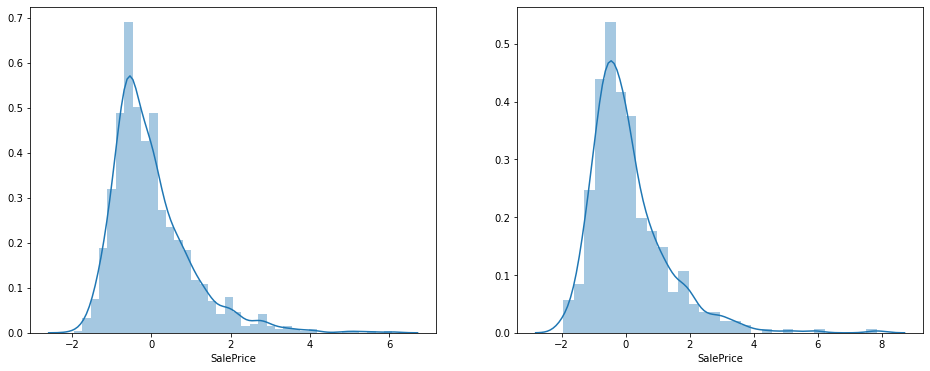

In [58]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(data_train.SalePrice)
plt.subplot(122)
sns.distplot(data_test.SalePrice)

### Prepare the X_train , y_train,X_test , y_test data for for modeling

In [59]:
# Start with area X_train, y_train

y_train = data_train.pop('SalePrice')
X_train = data_train

y_test = data_test.pop('SalePrice')
X_test = data_test

In [60]:
y_train.shape

(1008,)

In [61]:
X_train.shape

(1008, 202)

In [62]:
len(X_train.columns)

202

## Build Linear Regression Model using RFE to get optimal number of features

In [63]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

####  filtering the train and test set for the RFE selected columns

In [64]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

In [65]:
X_train.shape

(1008, 89)

In [66]:
X_train.columns

Index(['OverallQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'KitchenQual',
       'PoolArea', 'PoolQC', 'YearBuilt_Old', 'FV', 'RH', 'RL', 'RM', 'HLS',
       'NoSeWa', 'CulDSac', 'BrkSide', 'Crawfor', 'IDOTRR', 'NoRidge',
       'NridgHt', 'OldTown', 'Somerst', 'StoneBr', 'Veenker', 'RRAe', 'RRNn',
       'RRNn', 'Feedr', 'Feedr', 'PosA', 'PosA', 'PosN', 'PosN', 'RRAn',
       'RRAn', 'RRNn', 'RRNn', 'Duplex', 'Gable', 'Gambrel', 'Hip', 'Mansard',
       'Membran', 'Roll', 'Tar&Grv', 'WdShngl', 'CBlock', 'CBlock', 'CBlock',
       'ImStucc', 'ImStucc', 'Stone', 'Stone', 'Stone', 'Stone', 'Wd Sdng',
       'Wd Sdng', 'CBlock', 'CBlock', 'CBlock', 'CmentBd', 'Stone', 'Stone',
       'Stone', 'Stone', 'Wd Sdng', 'Wd Sdng', 'Slab', 'Wood', 'GasA', 'GasW',
       'Grav', 'OthW', 'Wall', 'FuseP', 'Sev', 'Typ', 'Con', 'ConLD', 'New',
       'AdjLand', 'Normal', 'Partial', 'Othr'],
      dtype='object')

### Ridge Implementation

In [67]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.8906895354267444
0.8396776543302664


## Above score represent overfitting, lets find optimal values of alpha using Grid search

In [68]:
folds  = KFold(n_splits=10,shuffle=True,random_state=100)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [69]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.003298,0.001880,0.001693,0.001097,0.001,{'alpha': 0.001},0.852715,0.763802,0.858947,0.886996,...,0.891436,0.888505,0.890753,0.891172,0.889937,0.894307,0.893892,0.890871,0.891824,0.001984
1,0.005586,0.006793,0.000498,0.001020,0.010,{'alpha': 0.01},0.852735,0.764049,0.858977,0.887024,...,0.891435,0.888504,0.890752,0.891171,0.889936,0.894305,0.893891,0.890870,0.891822,0.001984
2,0.003251,0.001755,0.001793,0.001323,0.100,{'alpha': 0.1},0.852918,0.766230,0.859002,0.887269,...,0.891344,0.888433,0.890666,0.891101,0.889825,0.894141,0.893789,0.890782,0.891727,0.001972
3,0.003655,0.004325,0.003072,0.004693,0.200,{'alpha': 0.2},0.853109,0.768200,0.858767,0.887493,...,0.891154,0.888280,0.890488,0.890946,0.889598,0.893819,0.893579,0.890591,0.891527,0.001949
4,0.004321,0.005910,0.002180,0.004635,0.500,{'alpha': 0.5},0.853691,0.772584,0.857770,0.888001,...,0.890470,0.887700,0.889845,0.890335,0.888802,0.892766,0.892834,0.889867,0.890801,0.001884


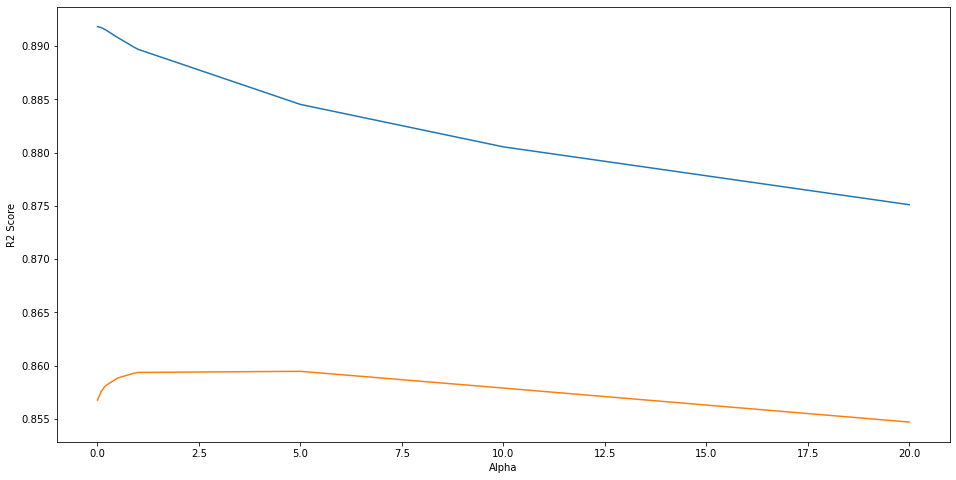

In [70]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

# Checking the best parameter(Alpha value)

In [71]:
model_cv.best_params_

{'alpha': 5.0}

In [72]:
ridge = Ridge(alpha = 5.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.8839752103183515
0.839857517655428


## Finding out coef & feature name

In [73]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = data_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature Name','Coef']

ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature Name,Coef
25,BsmtHalfBath,0.379356
51,YrSold_Old,0.373792
28,BedroomAbvGr,0.353755
24,BsmtFullBath,0.307524
85,Somerst,0.282518
29,KitchenAbvGr,0.265887
82,SWISU,0.258898
9,BsmtQual,0.244177
21,2ndFlrSF,0.238985
22,LowQualFinSF,0.227804


In [74]:
X_train.shape

(1008, 89)

In [75]:
X_train.columns

Index(['OverallQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'KitchenQual',
       'PoolArea', 'PoolQC', 'YearBuilt_Old', 'FV', 'RH', 'RL', 'RM', 'HLS',
       'NoSeWa', 'CulDSac', 'BrkSide', 'Crawfor', 'IDOTRR', 'NoRidge',
       'NridgHt', 'OldTown', 'Somerst', 'StoneBr', 'Veenker', 'RRAe', 'RRNn',
       'RRNn', 'Feedr', 'Feedr', 'PosA', 'PosA', 'PosN', 'PosN', 'RRAn',
       'RRAn', 'RRNn', 'RRNn', 'Duplex', 'Gable', 'Gambrel', 'Hip', 'Mansard',
       'Membran', 'Roll', 'Tar&Grv', 'WdShngl', 'CBlock', 'CBlock', 'CBlock',
       'ImStucc', 'ImStucc', 'Stone', 'Stone', 'Stone', 'Stone', 'Wd Sdng',
       'Wd Sdng', 'CBlock', 'CBlock', 'CBlock', 'CmentBd', 'Stone', 'Stone',
       'Stone', 'Stone', 'Wd Sdng', 'Wd Sdng', 'Slab', 'Wood', 'GasA', 'GasW',
       'Grav', 'OthW', 'Wall', 'FuseP', 'Sev', 'Typ', 'Con', 'ConLD', 'New',
       'AdjLand', 'Normal', 'Partial', 'Othr'],
      dtype='object')

### Lasso Implementation

In [76]:
X_train.shape

(1008, 89)

In [77]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8828799585994175
0.8437124760355074


In [78]:
X_train.shape

(1008, 89)

In [79]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = data_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', -0.98),
 ('LotArea', 0.197),
 ('LotShape', 0.139),
 ('LandSlope', 0.017),
 ('OverallQual', -0.0),
 ('OverallCond', 0.097),
 ('MasVnrArea', 0.012),
 ('ExterQual', 0.0),
 ('ExterCond', -0.031),
 ('BsmtQual', 0.425),
 ('BsmtCond', 0.179),
 ('BsmtExposure', 0.0),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', -0.104),
 ('BsmtFinType2', 0.0),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.151),
 ('TotalBsmtSF', -0.0),
 ('HeatingQC', 0.233),
 ('CentralAir', -0.0),
 ('1stFlrSF', 0.181),
 ('2ndFlrSF', 0.21),
 ('LowQualFinSF', 0.223),
 ('GrLivArea', 0.084),
 ('BsmtFullBath', 0.354),
 ('BsmtHalfBath', 0.433),
 ('FullBath', 0.022),
 ('HalfBath', 0.202),
 ('BedroomAbvGr', 0.432),
 ('KitchenAbvGr', 0.305),
 ('KitchenQual', -0.15),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.0),
 ('FireplaceQu', -0.092),
 ('GarageFinish', -0.0),
 ('GarageCars', 0.0),
 ('GarageArea', 0.0),
 ('GarageQual', -0.074),
 ('GarageCond', -0.0),
 ('WoodDeckSF', -0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorc

In [80]:
X_train.shape

(1008, 89)

## lets find optimal values of alpha using Grid search

In [81]:
folds = KFold(n_splits=10,shuffle=True,random_state=100)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [82]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.026790,0.007727,0.003257,0.004435,0.001,{'alpha': 0.001},0.856650,0.758627,0.845901,0.887251,...,0.883705,0.881852,0.883398,0.883250,0.881046,0.885060,0.885642,0.882674,0.883907,0.001907
1,0.005218,0.005711,0.002275,0.004915,0.010,{'alpha': 0.01},0.853260,0.763371,0.818877,0.859605,...,0.851034,0.845717,0.849739,0.850308,0.846649,0.846787,0.850012,0.844128,0.848566,0.002596
2,0.004224,0.005922,0.002171,0.004924,0.100,{'alpha': 0.1},0.811635,0.773576,0.832108,0.796966,...,0.798665,0.795767,0.798009,0.801626,0.793848,0.799028,0.798046,0.794284,0.798375,0.003014
3,0.004120,0.004425,0.001096,0.001131,1.000,{'alpha': 1.0},-0.025487,-0.018426,-0.000170,-0.007333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.004806,0.006138,0.002675,0.004502,5.000,{'alpha': 5.0},-0.025487,-0.018426,-0.000170,-0.007333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


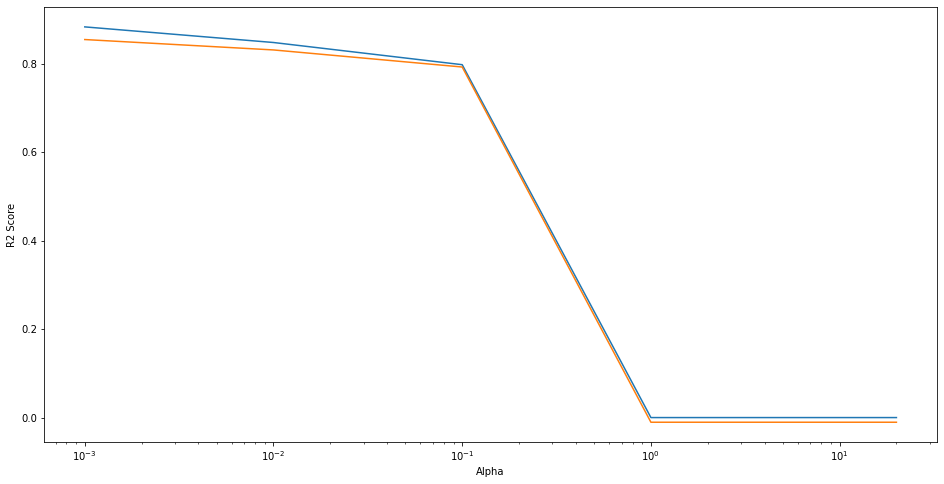

In [83]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [84]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0.001}

In [85]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8828799585994175
0.8437124760355074


In [86]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = data_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featre Name','Coef']

In [87]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featre Name,Coef
51,YrSold_Old,0.561327
25,BsmtHalfBath,0.432524
28,BedroomAbvGr,0.431583
9,BsmtQual,0.424751
85,Somerst,0.412611
24,BsmtFullBath,0.353740
29,KitchenAbvGr,0.305231
82,SWISU,0.271847
18,HeatingQC,0.233312
22,LowQualFinSF,0.223379


### Final Model is Lasso r2_score is almost same but r2_score for test set is better in Lasso as lasso will penalize more on the dataset and can also help in feature elimination i will consider Lasso as my final model.

In [88]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8828799585994175
0.8437124760355074


In [89]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = data_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featre Name','Coef']

In [90]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featre Name,Coef
51,YrSold_Old,0.561327
25,BsmtHalfBath,0.432524
28,BedroomAbvGr,0.431583
9,BsmtQual,0.424751
85,Somerst,0.412611
24,BsmtFullBath,0.353740
29,KitchenAbvGr,0.305231
82,SWISU,0.271847
18,HeatingQC,0.233312
22,LowQualFinSF,0.223379


### Conclusion 
##### YrSold       : Year Sold house 
##### BsmtHalfBath : Basement half bathrooms
##### BedroomAbvGr : Bedrooms above grade
##### BsmtQual     : Evaluates the height of the basement
##### Somerst      : Physical locations within Ames city limits
##### BsmtFullBath : Basement full bathrooms
##### KitchenAbvGr : Kitchens above grade
##### SWISU        : Physical locations within Ames city limits
##### HeatingQC    : Heating quality and condition
##### LowQualFinSF : Low quality finished square feet

## Assignment 2


### Doubling alpha for ridge regression optimal results

In [91]:
ridge = Ridge(alpha = 10.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.8802721126865349
0.8366758773087086


## Finding out coef & feature name after doubling alpha

In [92]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = data_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature Name','Coef']

ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature Name,Coef
25,BsmtHalfBath,0.320906
28,BedroomAbvGr,0.277947
24,BsmtFullBath,0.252771
51,YrSold_Old,0.243900
9,BsmtQual,0.242907
85,Somerst,0.236544
82,SWISU,0.235755
1,LotArea,0.213589
18,HeatingQC,0.199586
29,KitchenAbvGr,0.197319


In [93]:
#lasso = Lasso(alpha=0.002)
#lasso.fit(X_train,y_train)

#y_train_pred = lasso.predict(X_train)
#y_test_pred = lasso.predict(X_test)

#print(r2_score(y_true=y_train,y_pred=y_train_pred))
#print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [94]:
#model_param = list(lasso.coef_)
#model_param.insert(0,lasso.intercept_)
#cols = data_train.columns
#cols.insert(0,'const')
#lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
#lasso_coef.columns = ['Feature Name','Coef']

In [95]:
#lasso_coef.sort_values(by='Coef',ascending=False).head(10)

In [96]:
#### Lasso model again after droppping 5 columns from final modelb

In [97]:
X_train.shape

(1008, 89)

In [98]:
data.drop(columns=['YrSold_Old','BsmtHalfBath','BedroomAbvGr','BsmtQual','Somerst'], axis=1, inplace=True)

In [99]:
data_train, data_test = train_test_split(data,train_size=0.7, random_state=100)

# Perform scaling on training data using StandardScaler of numeric vars


In [100]:

# Instatiate asn object
scaler = StandardScaler()

# Scale only numeric variable
# Fit_transform on data

new_numeric_vars = ['MSSubClass','PoolArea','MasVnrArea','TotRmsAbvGrd','Fireplaces','KitchenAbvGr','FullBath','HalfBath','BsmtFullBath','GrLivArea','LowQualFinSF','2ndFlrSF','1stFlrSF','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1','OverallCond','OverallQual','LotArea','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','YearBuilt_Old','YearRemodAdd_Old','GarageYrBlt_Old',
           'SalePrice']

data_train[new_numeric_vars] = scaler.fit_transform(data_train[new_numeric_vars])
data_test[new_numeric_vars] = scaler.transform(data_test[new_numeric_vars])

In [101]:
# Start with area X_train, y_train

y_train = data_train.pop('SalePrice')
X_train = data_train

y_test = data_test.pop('SalePrice')
X_test = data_test

## Build Linear Regression Model using RFE to get optimal number of features

In [102]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

####  filtering the train and test set for the RFE selected columns

In [103]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

In [104]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8874993987060144
0.8296293141695116


In [105]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = data_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature Name','Coef']

In [106]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature Name,Coef
24,FullBath,0.428955
49,RH,0.422108
22,GrLivArea,0.376801
9,BsmtCond,0.361313
25,HalfBath,0.359600
82,Timber,0.338943
23,BsmtFullBath,0.301316
89,RRAn,0.277801
79,Sawyer,0.253255
14,BsmtFinSF2,0.252477
